In [1]:
# Import Depedencies / Libraries
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(autoload_with=engine)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Create an inspector to begin exploration by inspecting the tables' data
inspector = inspect(engine)
inspector.get_table_names()
station_columns = inspector.get_columns('station')
measurement_columns = inspector.get_columns('measurement')

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [10]:
# latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
# year_ago_date = (latestdate.year-1, latestdate.month, latestdate.day)
# year_ago_date

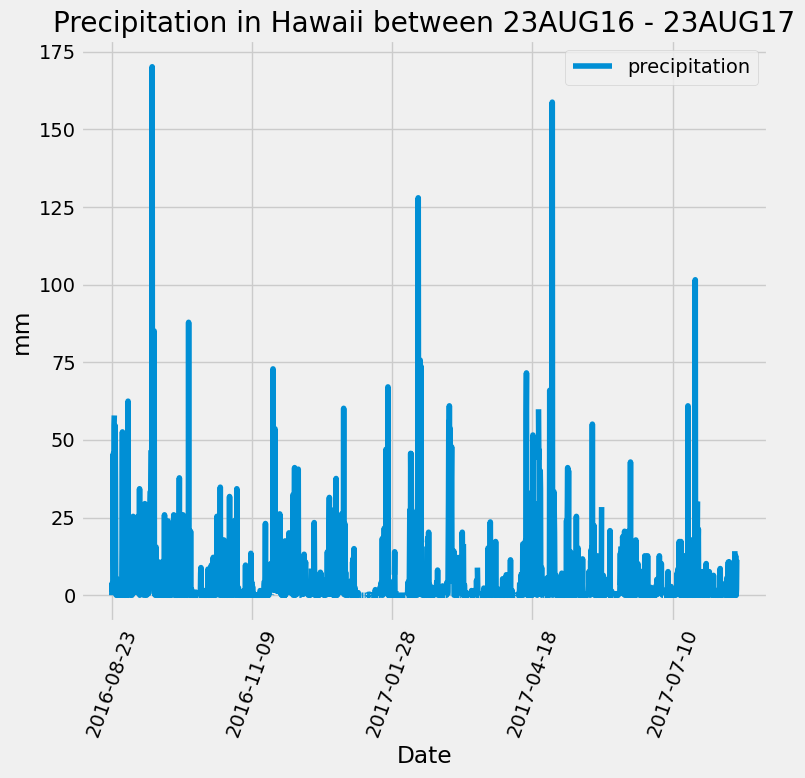

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores.
sel = [measurement.date, measurement.prcp]
twelve_months = session.query(*sel).\
    filter(measurement.date >= '2016-08-23').\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names.
# Sort the dataframe by date
prcp_df = pd.DataFrame(twelve_months, columns=['date', 'precipitation'])
# prcp_df.dropna(axis=0, how='any', inplace= True)
prcp_df.sort_values(by='date')
prcp_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=90, xlabel = 'Date', ylabel='mm', figsize=(8,8))
plt.title('Precipitation in Hawaii between 23AUG16 - 23AUG17')
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
stations_count = session.query(station.station).count()
stations_count

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
    
station_activity = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
most_active_stats = session.query(*sel).\
    filter(measurement.station == 'USC00519281')

for record in most_active_stats:
    print(record)

(12.2, 29.4, 22.03582251082252)


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
sel = [measurement.date, measurement.tobs]
active_station_twelve_months = session.query(*sel).\
    filter(measurement.date > '2016-08-23').\
    filter(measurement.station == 'USC00519281').\
    group_by(measurement.date).\
    order_by(measurement.date).all()

active_station_df = pd.DataFrame(active_station_twelve_months, columns=['date', 'tobs'])
active_station_df.sort_values(by='date')
active_station_df.set_index('date', inplace=True)
active_station_df.head()

,tobs
date,
2016-08-24,25.0
2016-08-25,26.7
2016-08-26,26.7
2016-08-27,23.9
2016-08-28,22.8


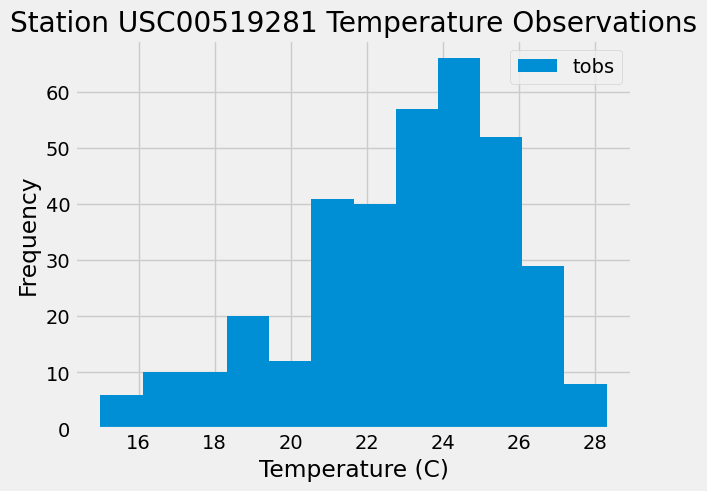

In [19]:
# Plot the results as a histogram
plt.hist(active_station_df['tobs'],bins=12, label="tobs")
plt.xlabel("Temperature (C)")
plt.ylabel("Frequency")
plt.title("Station USC00519281 Temperature Observations")
plt.figsize=(10,7)
plt.legend()
plt.show()

# Close Session

In [20]:
# Close Session
session.close()